![title_pic](./img/title_page.png)
#### TV & Movie recommendation system using a collaborative and content based filtering approach

# Project Overview
The main goal for this project is to Develop a hybrid movie/TV recommendation system that combines collaborative filtering and content-based filtering to suggest new content to users. Currently, these techniques are applied independently. Our project aims to harness their combined potential.

**Collaborative Filtering**: Analyzes existing user profiles to discover shared preferences and recommend new content based on similarities.

**Content-Based Filtering**: Suggests new content with similar fearures to the movie/TV show that you input.


# Business Understanding
As streaming platforms pile-up content, users struggle to pinpoint films or shows that align with their tastes. The dubious presence of bias in platform algorithms exacerbates this challenge, making it harder for users to rely on platform recommendations. Biases emerge from factors like skewed user preferences, popularity bias, or even the platform's promotional agenda. As a result, recommended content may not cater to users' unique tastes, negatively affecting the overall user experience.

Streaming platforms stand to gain from implementing an unbiased hybrid recommendation system that blends content-based and collaborative filtering techniques. This approach leverages the best of both methods, increasing reliability and personalization while mitigating biases. The content-based technique analyzes features like genre and content description, while collaborative filtering harnesses the collective trends of user ratings. Together, they forge a powerful recommendation engine, enhancing user satisfaction and overall experience.


# Content Based Filtering
The content-based filtering recommendation system utilizes a cleaned dataset with 67,935 movies and TV shows, spanning 24 genres with accurate summaries. The following steps outline its creation:


- Preprocessed 'description' using techniques such as removing stopwords, employing regexTokenizer, and applying WordNetLemmatizer from the NLTK module.
- Used a custom WordNet function, curtosy of The Flatiron School,d to translate NLTK POS tags to WordNet tags.
- Visually analyzed a frequency plot across all genre targets, created in the last project I collaborated on, [github found here.](https://github.com/ParkedHampster/Twitter-Brand-Perception) , to pinpoint & remove common words among genres, thus boosting the impact of extracted features via TfidfVectorizer.
- With the improved preprocessed 'description', TfidfVectorizer from scikit-learn extracted 460 common words across genres.
- One-hot encoded 'genre' column, resulting in 24 distinct genres as features. In total, 484 features were obtained, considering genres and frequent words. Restricted features to under 500 for better efficiency, reduced overfitting, and simpler model evaluation.

In [1]:
import pandas as pd
import numpy as np
import random
import re


from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from wordcloud import WordCloud

from code.viz import word_plot

sns.set()


# increasing display to view large descriptions and reviewText
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
content_based = pd.read_csv('./data/descript_cont_based.csv')
# content_based = content_based[(content_based['description'].str.len() >= 225)]
movie_df = content_based.copy()
content_based.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96877 entries, 0 to 96876
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        96877 non-null  object
 1   description  96876 non-null  object
 2   title        96877 non-null  object
 3   starring     96877 non-null  object
 4   movie_id     96877 non-null  object
dtypes: object(5)
memory usage: 3.7+ MB


In [3]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags

    Provided by Flatiron School
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [11]:
sw = set(stopwords.words('english'))

tokenizer = RegexpTokenizer('\w+')

lemmer = WordNetLemmatizer()

regex_template = r"[^\w\s]"

In [12]:
def preprocess_and_lemmatize(text):
    
    text = str(text)
    
    text = re.sub(regex_template, '', text)
    
    text = text.lower()

    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]

    lemmatized_words = [lemmer.lemmatize(word, pos=get_wordnet_pos(tag))
                        for word, tag in pos_tag(words)]
    
    return ' '.join(lemmatized_words)

In [6]:
def tokenize_sw(text):
    
    words = tokenizer.tokenize(text)

    words = [word for word in words if word not in sw]
    
    return ' '.join(words)

In [13]:
content_based['description'] = content_based['description'].apply(preprocess_and_lemmatize)
content_based.head()

genre   
0  Faith & Spirituality  \
1  Faith & Spirituality   
2  Faith & Spirituality   
3           Documentary   
4  Faith & Spirituality   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      description   
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        like new  \
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            steve green hide em heart 13 bible memory music videos child age vhs   
2                                                                                                                                                                                               

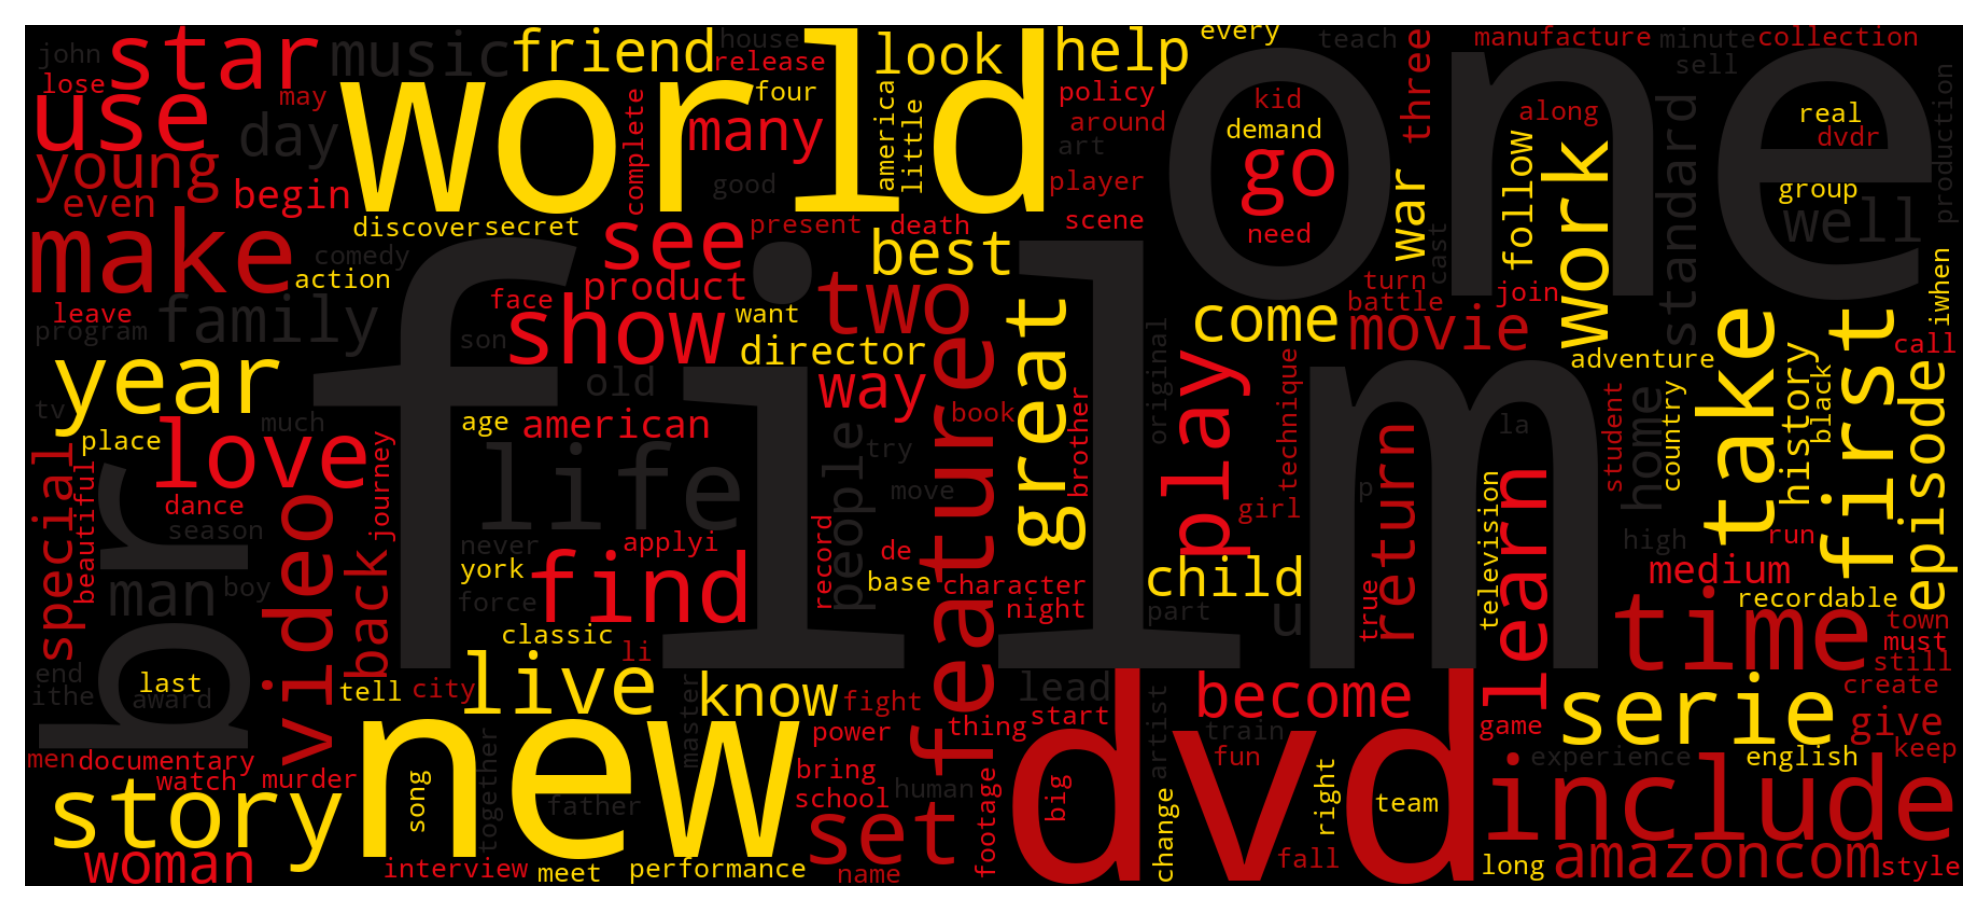

In [15]:
# This is the palette used in our associated
# presentation, available at a link later on
flix_colors = [
    "#221f1f", "#b9090b",
    "#e50914", "#ffd700"
]
canvamap = ListedColormap(flix_colors)


wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='black'
).generate(' '.join(content_based['description']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

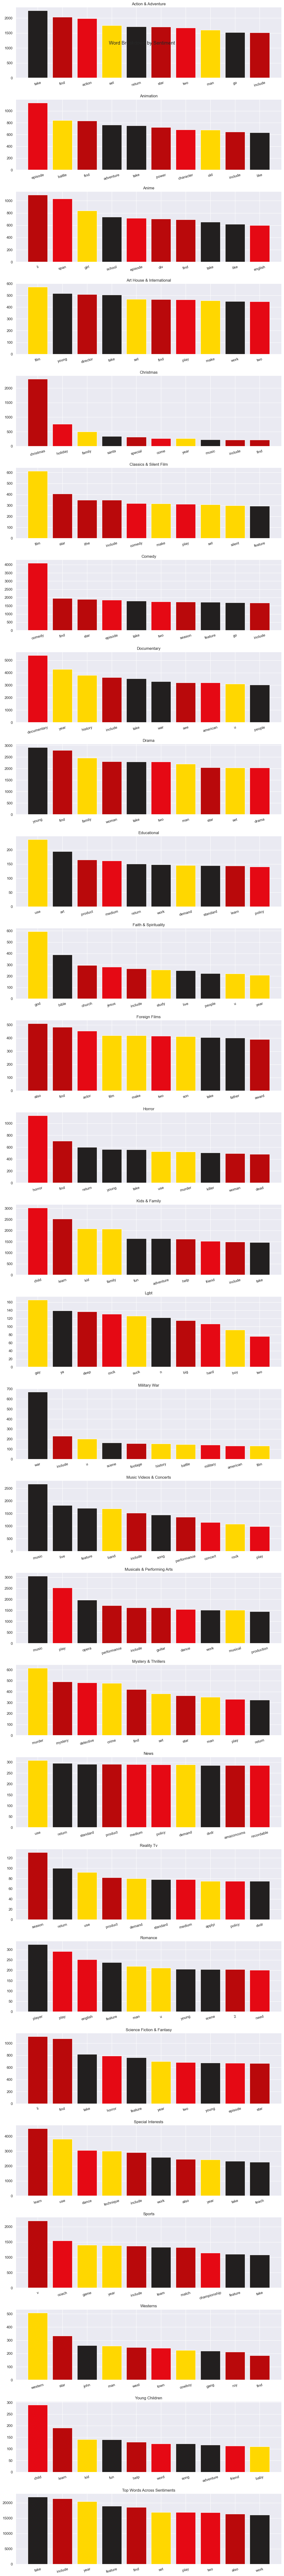

In [67]:
freq_words = word_plot(content_based, 'genre', 'description',
    n_words=10, theme=flix_colors)

In [68]:
specific_words = [
    'amazoncom', 'amazoncoms', 'dvdr', 'dvd', 'vcr','dvr',
    'vhs', 'demand', 'use', 'film', 'video', 'young', 'feature'
]

sw.extend(specific_words)

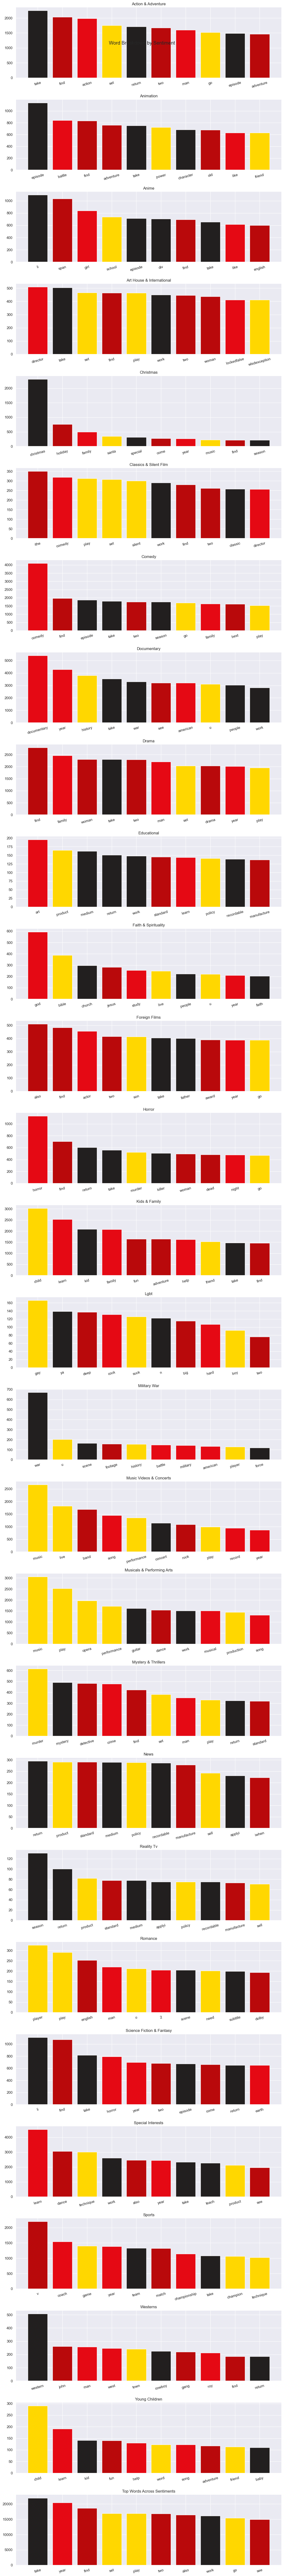

In [69]:
content_based['description'] = content_based['description'].apply(tokenize_sw)
freq_words = word_plot(content_based, 'genre', 'description',
    n_words=10, theme=flix_colors)

In [70]:
more_words = [
    'year', 'story', 'feature', 'time'
    ]
sw.extend(more_words)

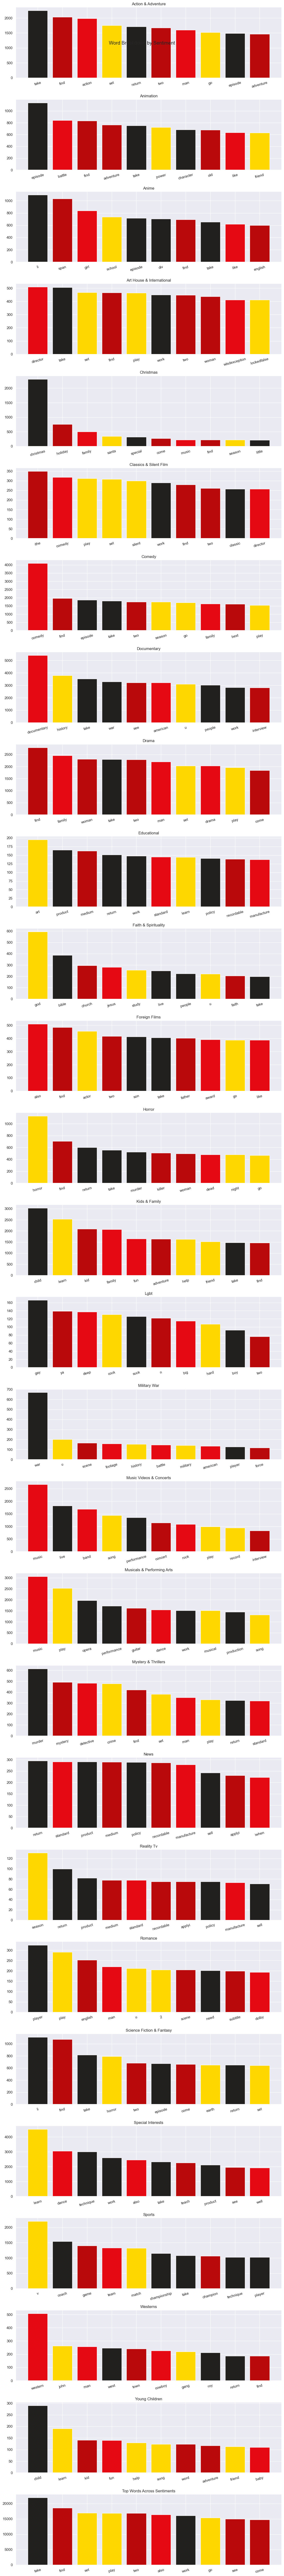

In [71]:
content_based['description'] = content_based['description'].apply(tokenize_sw)
freq_words = word_plot(content_based, 'genre', 'description',
    n_words=10, theme=flix_colors)

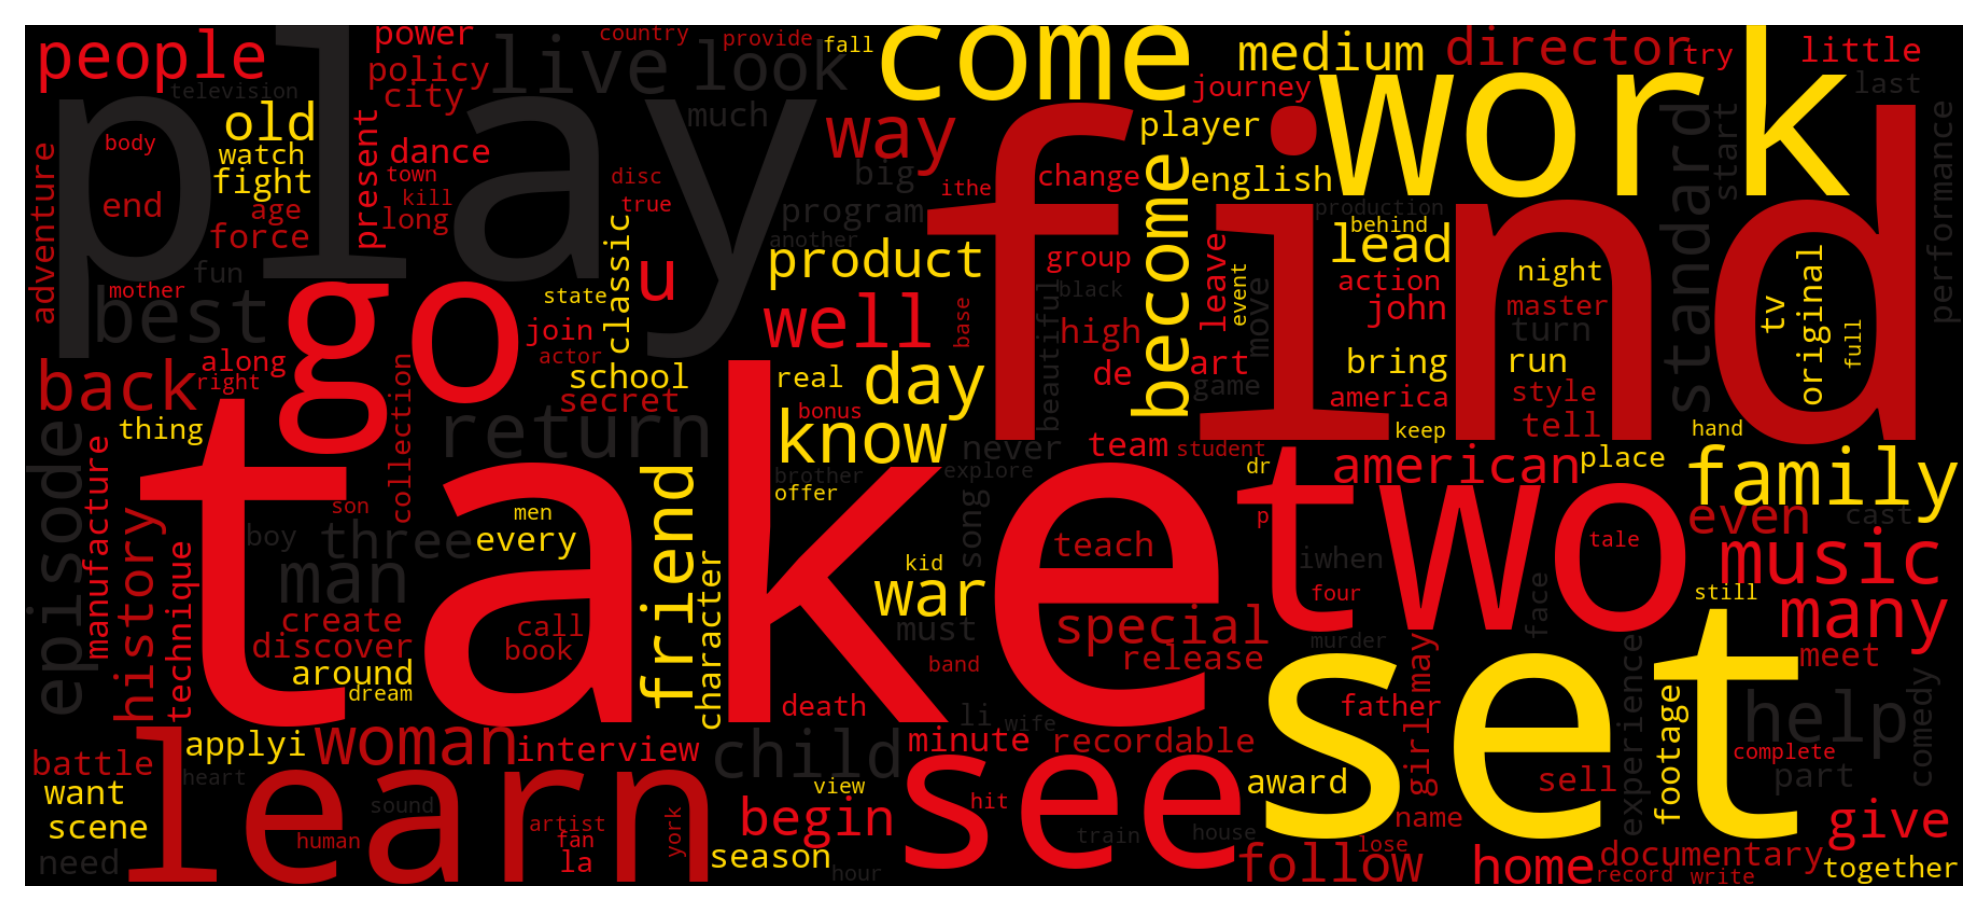

In [72]:
content_based['description'] = content_based['description'].apply(tokenize_sw)
wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='black'
).generate(' '.join(content_based['description']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [73]:
last_words = [
    'set','play','take'
    ]
sw.extend(last_words)

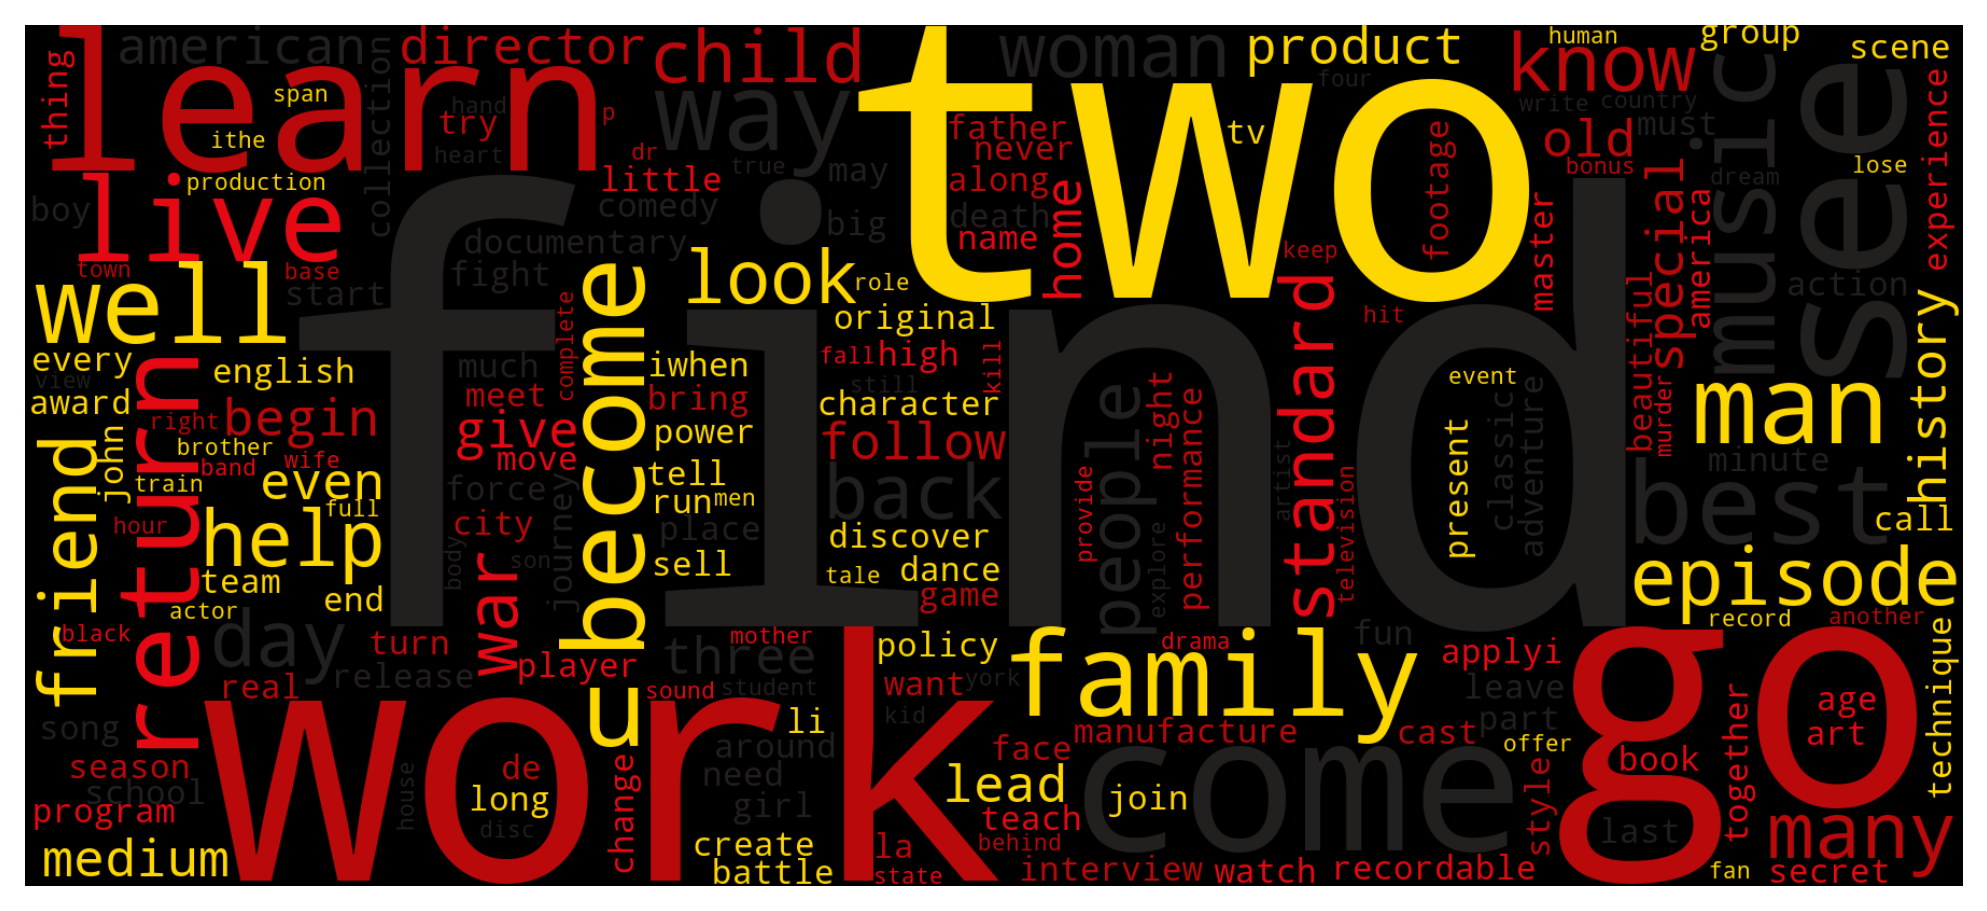

In [74]:
content_based['description'] = content_based['description'].apply(tokenize_sw)
wordcloud = WordCloud(
    collocations=False, width=1800, height=800,
    colormap=canvamap, background_color='black'
).generate(' '.join(content_based['description']))

plt.figure(figsize=(10, 14), dpi=250)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Analyzing preprocessing of description features:
With more time I'd like to further process the features found in descriptions. Thought there seems to be specific language that is unique to certain video genres there is still a lot of words that at first glance seemt to be general language used in all movie descriptions. With more time I'd like to be more specific about the words kept for the vectorized dataset.

Also, I'd like to analyze video content that is purely streaming video content. Currently the videos in this dataset make have a large portion that are DVD and Blu-Ray DVD and the descriptions for these videos may include language that describes the physical format that the video content is displayed on.

In [ ]:
content_based.to_csv('./data/nlp_descript_genre', encoding='utf-8', index=False)

In [5]:
content_based = pd.read_csv('./data/nlp_descript_genre')
content_based.dropna(subset='description',inplace=True)
movie_df=content_based.copy()
content_based.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80231 entries, 0 to 80232
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        80231 non-null  object
 1   description  80231 non-null  object
 2   title        80231 non-null  object
 3   starring     80231 non-null  object
 4   movie_id     80231 non-null  object
dtypes: object(5)
memory usage: 3.7+ MB


In [6]:
content_based.set_index('movie_id', inplace=True)
content_based.drop(columns=['title', 'starring'], inplace=True)
content_based = pd.get_dummies(content_based, columns=['genre'], dtype=int)

In [7]:
vectorizer = TfidfVectorizer(max_features=460)
tf_genre = vectorizer.fit_transform(content_based['description'])
tf_genre = pd.DataFrame(tf_genre.todense(), columns=vectorizer.get_feature_names_out(), index=content_based.index)

tf_genre = pd.concat([content_based.drop(['description'], axis=1), tf_genre], axis=1)
tf_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80231 entries, 0001421409 to B01HJCCLOY
Columns: 487 entries, genre_Action & Adventure to youll
dtypes: float64(460), int32(27)
memory usage: 290.4+ MB


### Similarity Algorithm Functions:

**cos_recs_genre()**: Calculates similarity scores between movies using cosine_similarity() from sklearn, leveraging TF-IDF features.

**knn_recs_genre()**: Employs NearestNeighbors model from sklearn with 'cosine' metric, conducting k-nearest neighbors search based on cosine similarity.

Both return the top 5 recommendations for a movie. The first calculates the cosine similarity matrix directly, while the second utilizes a k-nearest neighbors model.

### Performance & Evaluation:
The system performs well, suggesting new movies based on genre and word vector similarities. However, it leans towards movies of the same genre, working well for specific genres like 'Faith & Spirituality', but offering dissimilar recommendations for broader genres like 'Science Fiction & Fantasy'.

In [11]:
def cos_recs_genre(vectorized_df, movie_df, movie_id=None):
    
    # If no movie_id is given, randomly pick a movie_id from the available movie_ids
    if movie_id is None:
        movie_id = random.choice(movie_df['movie_id'])
    
    # Get the input movie's information (title, genre, and starring) from movie_df
    input_movie_info = movie_df.loc[movie_df.movie_id == movie_id, ['title', 'genre', 'starring']]
    
    # Calculate the cosine similarity matrix for the vectorized_df
    cosine_matrix = cosine_similarity(vectorized_df)
    
    # Extract similarity scores for the input movie from the cosine_matrix
    similarity_scores = pd.Series(cosine_matrix[vectorized_df.index.get_loc(movie_id)], index=vectorized_df.index)
    
    # Sort the similarity scores in descending order
    sorted_scores = similarity_scores.sort_values(ascending=False)
    
    # Get the top 5 recommended movies not including the input movie
    top_recommendations = sorted_scores.loc[sorted_scores.index != movie_id].head(5)
    
    # Retrieve the recommended movies' information (title, genre, starring, and movie_id) from movie_df
    recommended_movies = movie_df.loc[movie_df.movie_id.isin(top_recommendations.index), ['title', 'genre', 'starring', 'movie_id']]
    
    # Display the input movie's information
    print("Input movie information:")
    print(input_movie_info.to_string(index=False))
    
    # Return the top 5 recommended movies
    print("\nRecommended movies:")
    return recommended_movies

In [18]:
def knn_recs_genre(vectorized_df, movie_df, movie_id=None):
    # If no movie_id is given, randomly pick a movie_id from the available movie_ids
    if movie_id is None:
        movie_id = random.choice(movie_df['movie_id'])
        
    # Get the input movie's information (title, genre, and starring) from movie_df
    input_movie_info = movie_df.loc[movie_df.movie_id == movie_id, ['title', 'genre', 'starring']]

    # The features used for the k-Nearest Neighbor model
    features = vectorized_df

    # Initialize the k-Nearest Neighbor model with 6 neighbors and cosine distance metric
    model = NearestNeighbors(n_neighbors=6, metric='cosine')
    # Fit the model with the features (vectorized_df values)
    model.fit(features.values)

    # Find the distances and indices of the 6 nearest neighbors for the input movie's features
    distances, indices = model.kneighbors(features.loc[movie_id].to_numpy().reshape(1, -1), return_distance=True)

    # Get the top 5 recommended movies from the indices, excluding the input movie
    top_recommendations = [vectorized_df.index[i] for i in indices[0][1:]]
    
    # Retrieve the recommended movies' information (title, genre, starring, and movie_id) from movie_df
    recommended_movies = movie_df.loc[movie_df.movie_id.isin(top_recommendations), ['title', 'genre', 'starring','movie_id']]

    # Display the input movie's information
    print("Input movie information:")
    print(input_movie_info.to_string(index=False))
    
    # Return the top 5 recommended movies
    print("\nRecommended movies:")
    return recommended_movies

In [19]:
cosine_recommendations_genre = cos_recs_genre(tf_genre, movie_df)
cosine_recommendations_genre

Input movie information:
                          title genre             starring
Dragon Ball Z: Resurrection 'F' Anime Christopher R. Sabat

Recommended movies:


title   
19504                                                                                                                                                                                     Invader Zim 3 Pack  \
20458                                                                                                                                                                        Stratos 4 - Complete Collection   
22343                                                                                                                                                                            X TV Re-Mix Collector's Set   
42922  Feh&eacute;rl&oacute;fia 1982 / Hungarian cartoon / Region 2 PAL / Hungarian only version / Director: Marcell Jankovics Writers: L&aacute;szl&oacute; Gy&ouml;rgy (writer) Marcell Jankovics (writer)   
78684                                                                                                                                                                    One Piece: Season Seven, Voyage Six   

       genre              starring    movie_id  
19504  Anime       Various Artists  B000BOH9AY  
20458  Anime           Yumi Kakazu  B000CQQIAI  
22343  Anime       Various Artists  B000FFJ8S0  
42922  Anime       Various Artists  B001P82XPG  
78684  Anime  Colleen Clinkenbeard  B01ASMCHLE

In [21]:
cosine_recommendations_genre = cos_recs_genre(tf_genre, movie_df, movie_id ='B01ASMCHLE')
cosine_recommendations_genre

Input movie information:
                              title genre             starring
One Piece: Season Seven, Voyage Six Anime Colleen Clinkenbeard

Recommended movies:


title   
42922  Feh&eacute;rl&oacute;fia 1982 / Hungarian cartoon / Region 2 PAL / Hungarian only version / Director: Marcell Jankovics Writers: L&aacute;szl&oacute; Gy&ouml;rgy (writer) Marcell Jankovics (writer)  \
51115                                                                                                                                                                              Gun X Sword: The Complete   
57791                                                                                                                                                                 Hetalia: World Series 1 - Season Three   
63090                                                                                                                                                                             More Cartoons for Victory!   
66711                                                                                                                                                                        One Piece: Season 5, Voyage Two   

       genre              starring    movie_id  
42922  Anime       Various Artists  B001P82XPG  
51115  Anime         David Vincent  B0043988J4  
57791  Anime        Todd Haberkorn  B005W2BWPS  
63090  Anime             Mel Blanc  B00ADXU67Q  
66711  Anime  Colleen Clinkenbeard  B00DJ5IQ8Q

In [ ]:
### Relevance of Recommendations: 
The first input video is an Anime movie "Dragon Ball Z: Resurrection 'F'". All the recommended movies returned by this function are also from the Anime genre, which indicates  relevant recommendation based on content similarity.

In [22]:
knn_recommendations_genre = knn_recs_genre(tf_genre, movie_df, movie_id ='B01ASMCHLE')
knn_recommendations_genre

Input movie information:
                              title genre             starring
One Piece: Season Seven, Voyage Six Anime Colleen Clinkenbeard

Recommended movies:


title   
42922  Feh&eacute;rl&oacute;fia 1982 / Hungarian cartoon / Region 2 PAL / Hungarian only version / Director: Marcell Jankovics Writers: L&aacute;szl&oacute; Gy&ouml;rgy (writer) Marcell Jankovics (writer)  \
49428                                                                                                                                                              My Bride Is a Mermaid: Season 1, Part One   
51115                                                                                                                                                                              Gun X Sword: The Complete   
51708                                                                                                                                                                         Black Butler: Season 1, Part 1   
54147                                                                                                                                                                              One Piece: Collection One   

       genre              starring    movie_id  
42922  Anime       Various Artists  B001P82XPG  
49428  Anime        Todd Haberkorn  B003H6KRMK  
51115  Anime         David Vincent  B0043988J4  
51708  Anime      J. Michael Tatum  B004AJDEBE  
54147  Anime  Colleen Clinkenbeard  B004W75BQU

In [20]:
knn_recommendations_genre = knn_recs_genre(tf_genre, movie_df)
knn_recommendations_genre

Input movie information:
                           title  genre   starring
Creating the Complete Outfielder Sports Kyla Holas

Recommended movies:


title   genre   
1194                    Tips for Tying Better Classic Atlantic Salmon  Sports  \
5945   Lenny Wilkens Legacy Basketball Clinic Series - The Basics VHS  Sports   
20497                                                    Wet Fly Ways  Sports   
27573                                       Backstroke for Every Body  Sports   
65765                        Kevin Swartwood: Shotgun Fly Sweep (DVD)  Sports   

              starring    movie_id  
1194   Various Artists  1932978933  
5945     Lenny Wilkens  B00000JNWT  
20497      Davy Wotton  B000CR7U90  
27573   Terry Laughlin  B000NA6WEA  
65765  Kevin Swartwood  B00CIBATQE

### Overall Similarity Function Evaluations:
The systems appear to perform well, suggesting new content based on genre. However, it leans towards movies of the same genre, working well in this dataset for more specific genres like 'Anime' and 'Faith & Spirituality', but offering dissimilar recommendations for broader genres in the dataset like 'Comedy'.

# Conclusions
**Preprocessing Evaluation**: Enhancing preprocessing for the 'description' column may better recognize genre-specific language. Also, concentrating solely on streaming content could reduce biases arising from physical format descriptions.

**Function Recommendations Evaluation**: Similarity functions exhibit encouraging outcomes, especially for genres such as 'Anime' and 'Faith & Spirituality'. However, we can refine them to better address wider genres like 'Comedy'. Concise and focused explanations are vital.